In [3]:
import matplotlib.pylab as plt 

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import numpy
import math
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np



# Part 1: TF Hub

## Load Classifier

In [4]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/inception_v3/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              23853833  
Total params: 23,853,833
Trainable params: 0
Non-trainable params: 23,853,833
_________________________________________________________________


## Load image from the internet

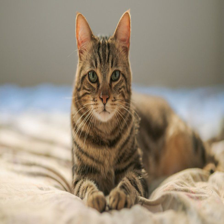

In [6]:
import numpy as np
import PIL.Image as Image

img = tf.keras.utils.get_file('cat.jpg','https://ichef.bbci.co.uk/news/976/cpsprodpb/12A9B/production/_111434467_gettyimages-1143489763.jpg')
img = Image.open(img).resize((IMAGE_RES, IMAGE_RES))
img 

In [7]:
img = np.array(img)/255.0
img= img[:,:,:3]
img.shape

(224, 224, 3)

## Predict image class

In [8]:
result = model.predict(img[np.newaxis, ...])
result.shape

(1, 1001)

In [9]:
print (img.shape)
print (img[np.newaxis, ...].shape)
print (np.array([img]).shape)

(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

282

## Get classes names and assign predicted class

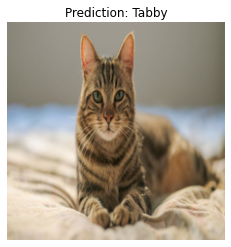

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(img)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Part 2: TF Hub for Cats VS Dogs

## Load data

In [12]:
(train_examples, validation_examples), info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [13]:
num_examples

3670

In [14]:
num_classes

5

In [15]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (333, 500, 3)
Image 2 shape: (212, 320, 3)
Image 3 shape: (240, 320, 3)


In [16]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [17]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['picket fence', 'daisy', 'daisy', 'sea urchin', 'sea urchin',
       'maypole', "yellow lady's slipper", 'king crab', 'daisy',
       'bottlecap', 'picket fence', 'goldfinch', 'picket fence', 'daisy',
       'daisy', 'daisy', 'daisy', 'bee', 'quill', 'lorikeet', 'daisy',
       'greenhouse', 'pot', 'vase', 'hip', 'artichoke', 'daisy',
       'sea urchin', 'admiral', 'daisy', 'greenhouse', 'paintbrush'],
      dtype='<U30')

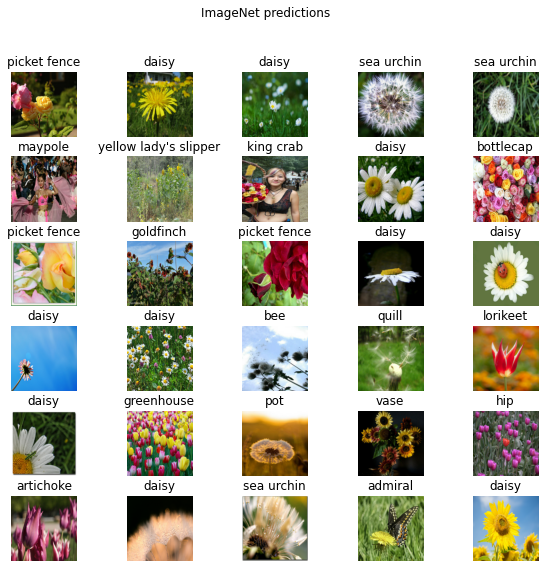

In [18]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## Get the model

In [19]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [20]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 2048)


In [21]:
feature_extractor.trainable = False

In [22]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


## Train the model

In [23]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 2
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/2
81/81 [==============================] - 349s 4s/step - loss: 0.9477 - accuracy: 0.6458 - val_loss: 0.4946 - val_accuracy: 0.8229
Epoch 2/2
81/81 [==============================] - 323s 4s/step - loss: 0.4326 - accuracy: 0.8443 - val_loss: 0.4364 - val_accuracy: 0.8429


## Visualize training history

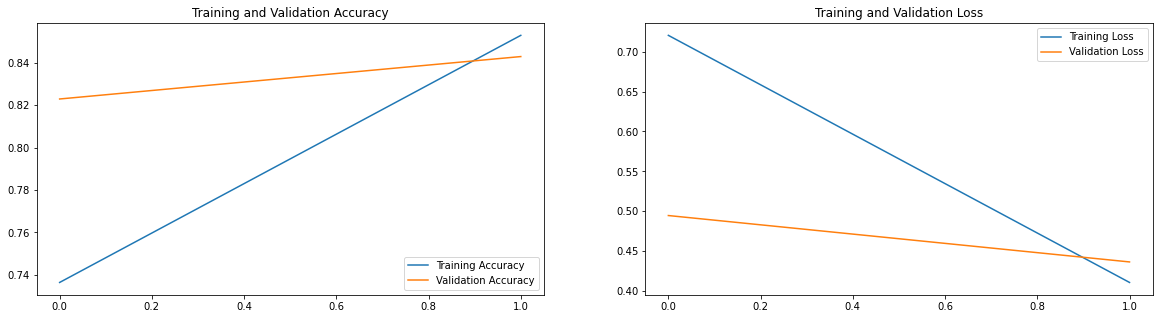

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
class_names = np.array(info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [26]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['roses', 'sunflowers', 'daisy', 'dandelion', 'dandelion', 'daisy',
       'sunflowers', 'roses', 'daisy', 'roses', 'roses', 'sunflowers',
       'roses', 'daisy', 'daisy', 'daisy', 'daisy', 'dandelion',
       'dandelion', 'tulips', 'daisy', 'tulips', 'dandelion',
       'sunflowers', 'tulips', 'tulips', 'dandelion', 'dandelion',
       'daisy', 'sunflowers', 'roses', 'tulips'], dtype='<U10')

In [27]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [4 0 1 0 0 4 3 4 1 4 4 3 4 1 1 1 1 0 0 2 1 2 0 3 2 2 0 0 0 3 4 2]
Predicted labels:  [4 3 1 0 0 1 3 4 1 4 4 3 4 1 1 1 1 0 0 2 1 2 0 3 2 2 0 0 1 3 4 2]


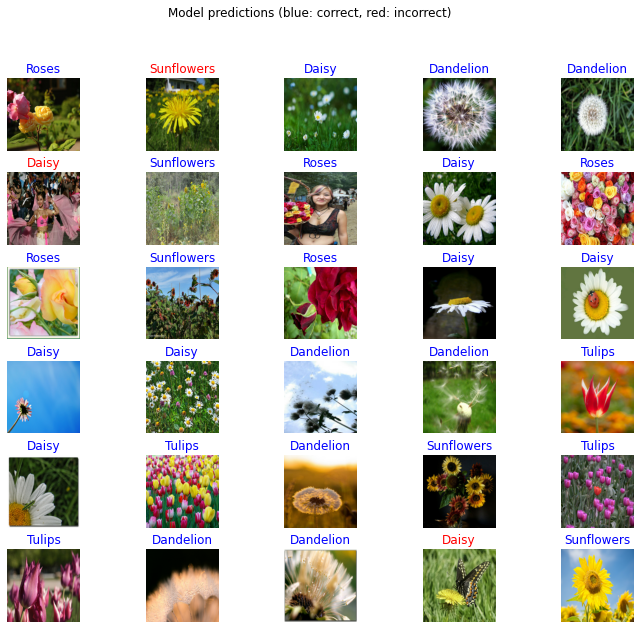

In [28]:
plt.figure(figsize=(12,10))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [ ]:
y_pred = model.predict(train_batches)

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = tf.concat([y for x, y in train_batches], axis=0)

cm=confusion_matrix(predicted_categories, true_categories)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
cm_plot_labels = ['no_side_effects','had_side_effects']

Confusion matrix, without normalization
[[186 118 142 129 126]
 [ 97  69  80  81  70]
 [131  94 113  97  97]
 [110  73  91  82  69]
 [115  91 105 107  96]]


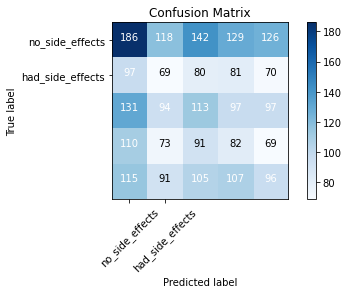

In [35]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')